In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
from scipy.optimize import minimize

# import packages
import glob
from pathlib import Path
import os
import geopandas as gpd
import iris
import iris.pandas
import numpy as np
from esmvalcore import preprocessor
from iris.coords import DimCoord
from iris.cube import Cube
from pathos.threading import ThreadPool as Pool
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr

In [2]:
work_dir=Path('/scratch/fransjevanoors/global_sr')
#work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
data_dir=Path(f'{work_dir}/data')
out_dir = Path(f"{work_dir}/output")

print(work_dir)
print(out_dir)
print(data_dir)



/scratch/fransjevanoors/global_sr
/scratch/fransjevanoors/global_sr/output
/scratch/fransjevanoors/global_sr/data


In [3]:
from f_sr_calculation import *
from f_sr_reference_data import *

### match stocker and lan values with catchment shapes

In [4]:
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str)[0:5]
work_dir_list = [work_dir]*len(catch_id_list)
run_stocker_sr_parallel(catch_id_list,work_dir_list)

In [44]:
catch_id_list = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str)[0:5]
work_dir_list = [work_dir]*len(catch_id_list)
run_lan_sr_parallel(catch_id_list,work_dir_list)

In [21]:
catch_id = catch_id_list[4]


In [42]:
def lan_to_shape_values(catch_id,work_dir):
    catchment_shapefile =  glob.glob(f'{work_dir}/output/selected_shapes/{catch_id}.shp')[0]    
    # LAN CRU
    rp = ['2yrs','5yrs','10yrs','20yrs','30yrs','40yrs','50yrs','60yrs','max']
    df_cru = pd.DataFrame(index=[catch_id], columns=[])
    for i in rp:
        catchment_netcdf= glob.glob(f'{work_dir}/data/reference_sr/lan/sr_cru_{i}.nc')[0]

        # Load iris cube of netcdf
        cube = iris.load_cube(catchment_netcdf)
        cube.dim_coords[1].guess_bounds()
        cube.dim_coords[2].guess_bounds()

        # Create target grid and regrid cube to higher resolution (0.1) because 0.5 is coarse
        grid_resolution = 0.1
        target_cube = regridding_target_cube(catchment_shapefile, grid_resolution, buffer=1) #create the regrid target cube
        cube = preprocessor.regrid(cube, target_cube, scheme="nearest") #regrid the netcdf file with nearest neighbour (most logical for sr values I think)

        # From cube extract shapefile shape
        cube = preprocessor.extract_shape(cube, catchment_shapefile, method="contains") #use all grid cells that lie >50% inside the catchment shape

        # Calculate area weighted statistics of extracted grid cells (inside catchment shape)
        cube_stats = preprocessor.area_statistics(cube, 'mean')

        # from cube to xarray dataarray
        a=xr.DataArray.from_iris(cube_stats)
        df_cru[f'lan_cru_{i}'] = a.values

    # LAN CHIRPS
    rp = ['2yrs','5yrs','10yrs','20yrs','30yrs','40yrs','50yrs','60yrs','max']
    df_chirps = pd.DataFrame(index=[catch_id], columns=[])
    for i in rp:
        catchment_netcdf= glob.glob(f'{work_dir}/data/reference_sr/lan/sr_chirps_{i}.nc')[0]

        # Load iris cube of netcdf
        cube = iris.load_cube(catchment_netcdf)
        cube.dim_coords[1].guess_bounds()
        cube.dim_coords[2].guess_bounds()

        # Create target grid and regrid cube to higher resolution (0.1) because 0.5 is coarse
        grid_resolution = 0.1
        target_cube = regridding_target_cube(catchment_shapefile, grid_resolution, buffer=1) #create the regrid target cube
        cube = preprocessor.regrid(cube, target_cube, scheme="nearest") #regrid the netcdf file with nearest neighbour (most logical for sr values I think)

        # From cube extract shapefile shape
        cube = preprocessor.extract_shape(cube, catchment_shapefile, method="contains") #use all grid cells that lie >50% inside the catchment shape

        # Calculate area weighted statistics of extracted grid cells (inside catchment shape)
        cube_stats = preprocessor.area_statistics(cube, 'mean')

        # from cube to xarray dataarray
        a=xr.DataArray.from_iris(cube_stats)
        df_chirps[f'lan_chirps_{i}'] = a.values   

    df = pd.concat([df_chirps,df_cru],axis=1)
    df.to_csv(f'{work_dir}/output/sr_calculation/lan/{catch_id}.csv')
    

In [43]:
def run_lan_sr_parallel(
    catch_id_list=list,
    work_dir_list=list,
    # threads=None
    threads=100
):
    """
    Runs function area_weighted_shapefile_rasterstats in parallel.

    catch_list:  str, list, list of catchment ids
    work_dir_list: str, list, list of work directories
    threads:         int,       number of threads (cores), when set to None use all available threads

    Returns: None
    """
    # Set number of threads (cores) used for parallel run and map threads
    if threads is None:
        pool = Pool()
    else:
        pool = Pool(nodes=threads)
    # Run parallel models
    results = pool.map(
        lan_to_shape_values,
        catch_id_list,
        work_dir_list,
    )

In [41]:
df

,lan_chirps_2yrs,lan_chirps_5yrs,lan_chirps_10yrs,lan_chirps_20yrs,lan_chirps_30yrs,lan_chirps_40yrs,lan_chirps_50yrs,lan_chirps_60yrs,lan_chirps_max,lan_cru_2yrs,lan_cru_5yrs,lan_cru_10yrs,lan_cru_20yrs,lan_cru_30yrs,lan_cru_40yrs,lan_cru_50yrs,lan_cru_60yrs,lan_cru_max
es_0001076,78.863686,102.800903,118.647049,133.84613,142.591766,148.757202,153.522552,157.407822,106.803627,64.112114,85.255142,99.251663,112.678635,120.402695,125.849594,130.059906,133.490143,97.574142


In [39]:
df

,lan_chirps_2yrs,lan_chirps_5yrs,lan_chirps_10yrs,lan_chirps_20yrs,lan_chirps_30yrs,lan_chirps_40yrs,lan_chirps_50yrs,lan_chirps_60yrs,lan_chirps_max,lan_cru_2yrs,lan_cru_5yrs,lan_cru_10yrs,lan_cru_20yrs,lan_cru_30yrs,lan_cru_40yrs,lan_cru_50yrs,lan_cru_60yrs,lan_cru_max
es_0001076,72.23793,94.589561,109.387154,123.580086,131.746094,137.504501,141.952835,145.581146,99.310143,59.396069,79.124588,92.185287,104.714149,111.921814,117.003494,120.932442,124.133842,90.98909


In [33]:
df_cru

,lan_cru_2yrs,lan_cru_5yrs,lan_cru_10yrs,lan_cru_20yrs,lan_cru_30yrs,lan_cru_40yrs,lan_cru_50yrs,lan_cru_60yrs,lan_cru_max
es_0001076,59.396069,79.124588,92.185287,104.714149,111.921814,117.003494,120.932442,124.133842,90.98909


In [34]:
df_chirps

,lan_chirps_2yrs,lan_chirps_5yrs,lan_chirps_10yrs,lan_chirps_20yrs,lan_chirps_30yrs,lan_chirps_40yrs,lan_chirps_50yrs,lan_chirps_60yrs,lan_chirps_max
es_0001076,72.23793,94.589561,109.387154,123.580086,131.746094,137.504501,141.952835,145.581146,99.310143


In [24]:
## 1 
def regridding_target_cube(catchment_shapefile, spatial_resolution, buffer=1):
    
    """
    Define the target cube for regridding the input netcdf data
    catchment_shapefile:  str, catchment shapefile
    spatial_resolution:   float, target resolution
    buffer:               int, buffer
    
    returns:
    target cube for regridding
    
    """    
    catchment_bounds = gpd.read_file(catchment_shapefile).bounds

    buffer = 1
    minx = int(catchment_bounds.minx.values[0]) - buffer
    maxx = int(catchment_bounds.maxx.values[0]) + buffer
    miny = int(catchment_bounds.miny.values[0]) - buffer
    maxy = int(catchment_bounds.maxy.values[0]) + buffer

    latitude = DimCoord(
        np.linspace(
            miny,
            maxy,
            int(np.divide(abs(miny-maxy), spatial_resolution)),
            dtype=float,
        ),
        standard_name="latitude",
        units="degrees",
    )
    latitude.guess_bounds()
    
    longitude = DimCoord(
        np.linspace(
            minx,
            maxx,
            int(np.divide(abs(minx-maxx), spatial_resolution)),
            dtype=float,
        ),
        standard_name="longitude",
        units="degrees",
    )
    longitude.guess_bounds()
    
    target_cube = Cube(
        np.zeros((len(latitude.points), len(longitude.points)), np.float32),
        dim_coords_and_dims=[(latitude, 0), (longitude, 1)],
    )

    return target_cube

## update sr calculation

In [18]:
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
c = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str) 
# catch_id = 'ar_0000023'
catch_id = c[100]
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')[:]
snow_dir = f'{work_dir}/output/snow/timeseries'

In [19]:
sd=run_sd_calculation(catch_id, pep_dir, q_dir, out_dir,snow_id_list,snow_dir)

IndexError: list index out of range

<AxesSubplot:>

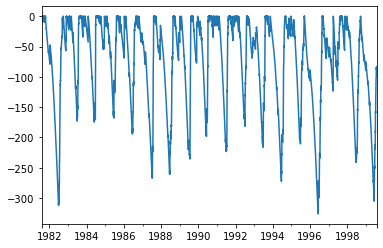

In [16]:
sd.Sd.plot()

In [17]:
# run max min root zone year
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments'

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60]

run_sr_calculation(catch_id, rp_array, sd_dir, out_dir)

,2,3,5,10,20,30,40,50,60
mx_0000012,217.805437,240.385796,265.535445,297.136863,327.449702,344.88793,357.18242,366.686562,374.435623


In [ ]:
# define directories
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

In [ ]:
## 1
def sd_initial(df, si_0, si_max, q_mean):
    """
    calculate timeseries of storage deficits

    df:       pandas dataframe, daily values for P, and Ep and date_start and date_end (defined in (2))
    si_0:     int, initial interception storage = 0
    si_max:   int, maximum interception storage = 2.5 mm
    q_mean:   df, catchment mean discharge

    returns: 
    b:        int, 1>non closing water balance, 0>closing water balance
    df:       pandas dataframe, daily values for P, Pe, Ep, Ei, Et, Sd
    """
    
    # add year if the start date is earlier than the timeseries (e.g. startdate 02-01, timeseries starts 02-28) 
    if df.index[0]>df.date_start[0]:
        df.date_start = df.date_start[0] + relativedelta(years=1)
    
    # select time period of interest
    df = df.loc[df.date_start[0]:df.date_end[0]]
    
    # add empty columns for interception storage calculation
    df.loc[:,'Si_1'] = np.nan
    df.loc[:,'Pe'] = np.nan
    df.loc[:,'Si_2'] = np.nan
    df.loc[:,'Ei'] = np.nan
    df.loc[:,'Si_3'] = np.nan
    df.loc[:,'Et'] = np.nan
    df.loc[:,'Sd'] = np.nan
    
    # convert to numpy arrays (to speed up calculations)
    p = np.array(df.p.values)
    ep = np.array(df.ep.values)
    
    si1 = np.zeros(len(df))
    pe = np.zeros(len(df))
    si2 = np.zeros(len(df))
    ei = np.zeros(len(df))
    si3 = np.zeros(len(df))
    et = np.zeros(len(df))
    sd = np.zeros(len(df))
    
    #calculate interception storage and effective precipitation for all timesteps
    for l in range(1,len(si1)):
        # first timestep l=0
        si1[0] = p[0] + si_0
        pe[0] = max(0,si1[0]-si_max)
        si2[0] = si1[0] - pe[0]
        ei[0] = min(si2[0],ep[0])
        si3[0] = si2[0] - ei[0]
    
        # timestep 1 to end
        si1[l] = p[l] + si3[l-1]
        pe[l] = max(0,si1[l]-si_max)
        si2[l] = si1[l] - pe[l]
        ei[l] = min(si2[l],ep[l])
        si3[l] = si2[l] - ei[l]
    
    #calculate Et from the catchment water balance (Et = Pe-Q)
    Pe_mean = np.mean(pe)
    EP_mean = np.mean(ep)
    Q_mean = q_mean #q_mean from other file than p and e because yearly timeseries
    Et_mean = Pe_mean - Q_mean
    
    #check if water balance is ok
    if Et_mean<0: # if this is the case, it is not possible to calculate sd
        b = 1 # wb not ok
        sd[:] = np.nan
        et[:]=np.nan
    else:
        b = 0 # wb ok
        #calculate daily Et (EP(daily)*(Et_sum/EP_sum)) and Sd
        for l in range(1,np.size(df.index)):
            # sd for timestep 0
            et[0] = ep[0]/EP_mean * Et_mean
            sd[0] = min(0,pe[0] - et[0])

            # sd for timestep 1 - end
            et[l] = ep[l]/EP_mean * Et_mean
            sd[l] = min(0,sd[l-1]+pe[l]-et[l])

    # add numpy arrays to dataframe
    df.Si_1 = si1
    df.Si_2 = si2
    df.Si_3 = si3
    df.Pe = pe
    df.Ei = ei
    df.Sd = sd
    df.Et = et
    
    # if(df.Sd.mean()==0):
    #     df.Sd=np.nan
    
    return b, df

In [20]:
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
c = np.loadtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype=str) 
catch_id = 'ar_0000023'
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')[:]
snow_dir = f'{work_dir}/output/snow/timeseries'


In [32]:
# run calculation of storage deficits (1)

# catch_id:    str, catchment id
# pep_dir:     str, dir, directory of P and Ep timeseries
# q_dir:       str, dir, directory of Q timeseries
# out_dir:     str, dir, output directory

# returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
# """

if catch_id in snow_id_list:
    s = 1 # snow is yes
    f_pep = glob.glob(f'{snow_dir}/{catch_id}*.csv')

else:
    s = 0 # snow is no
    # get P Ep and Q files for catch id
    f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')

# read q df
f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

# read files as dataframes
q_ts = pd.read_csv(f_q[0],index_col=0)
q_ts.index = pd.to_datetime(q_ts.index)
pep_ts = pd.read_csv(f_pep[0],index_col=0)
pep_ts.index = pd.to_datetime(pep_ts.index)

if (s==1): #snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep','ps','pm','pl'])
    df_monthly[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    df_monthly_mean['liq'] = df_monthly_mean['pm'] + df_monthly_mean['pl']
    wettest_month = (df_monthly_mean['liq']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

else: # no snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
    df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

# find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
p_ep_start_year = pep_ts.index.year[0]
q_start_year = int(q_ts.index[0].year)
p_ep_end_year = pep_ts.index.year[-1]
q_end_year = int(q_ts.index[-1].year)

# test if timeseries have overlap -> if not don't continue the sd calculation
if q_start_year>p_ep_end_year:
    a=1
elif p_ep_start_year>q_end_year:
    a=1
else:
    a=0
    start_year = max(q_start_year,p_ep_start_year)
    end_year = min(q_end_year,p_ep_end_year)
    start_date = datetime(start_year,hydro_year_start_month,1)
    end_date = datetime(end_year,hydro_year_start_month,1)
    end_date = end_date - timedelta(days=1)

    #calculate mean Q for startdate enddate timeseries
    q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

    if (s==1): # snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','ps','pm','pl','date_start','date_end'])
        sd_input[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage
        
    else: # no snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
        sd_input[['p','ep']] = pep_ts[['p','ep']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

#     # run sd calculation
#     b = sd_initial(sd_input, si_0, si_max, q_mean)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
#     if b==0:      
#         # save output dataframe from sd calculation
#         out = sd_initial(sd_input, si_0, si_max, q_mean)[1]
#         out.to_csv(f'{out_dir}/{catch_id}.csv')

In [34]:
df = sd_input

In [35]:
# add year if the start date is earlier than the timeseries (e.g. startdate 02-01, timeseries starts 02-28) 
if df.index[0]>df.date_start[0]:
    df.date_start = df.date_start[0] + relativedelta(years=1)

# select time period of interest
df = df.loc[df.date_start[0]:df.date_end[0]]

# add empty columns for interception storage calculation
df.loc[:,'Si_1'] = np.nan
df.loc[:,'Pe'] = np.nan
df.loc[:,'Si_2'] = np.nan
df.loc[:,'Ei'] = np.nan
df.loc[:,'Si_3'] = np.nan
df.loc[:,'Et'] = np.nan
df.loc[:,'Sd'] = np.nan

# convert to numpy arrays (to speed up calculations)
p = np.array(df.p.values)
ep = np.array(df.ep.values)

if (s==1):
    pl = np.array(df.pl.values)
    pm = np.array(df.pm.values)

si1 = np.zeros(len(df))
pe = np.zeros(len(df))
pef = np.zeros(len(df))
si2 = np.zeros(len(df))
ei = np.zeros(len(df))
si3 = np.zeros(len(df))
et = np.zeros(len(df))
sd = np.zeros(len(df))

if (s==1): # snow
    #calculate interception storage and effective precipitation for all timesteps
    for l in range(1,len(si1)):
        # first timestep l=0
        si1[0] = pl[0] + si_0
        pef[0] = max(0,si1[0]-si_max)
        si2[0] = si1[0] - pef[0]
        ei[0] = min(si2[0],ep[0])
        si3[0] = max(0,si2[0]-ei[0])
        
        pe[0] = pef[0]+pm[0]

        # timestep 1 to end
        si1[l] = pl[l] + si3[l-1]
        pef[l] = max(0,si1[l]-si_max)
        si2[l] = si1[l] - pef[l]
        ei[l] = min(si2[l],ep[l])
        si3[l] = max(0,si2[l]-ei[l])
        
        pe[l] = pef[l]+pm[l]
            
else: # no snow
    #calculate interception storage and effective precipitation for all timesteps
    for l in range(1,len(si1)):
        # first timestep l=0
        si1[0] = p[0] + si_0
        pe[0] = max(0,si1[0]-si_max)
        si2[0] = si1[0] - pe[0]
        ei[0] = min(si2[0],ep[0])
        si3[0] = max(0,si2[0]-ei[0])

        # timestep 1 to end
        si1[l] = p[l] + si3[l-1]
        pe[l] = max(0,si1[l]-si_max)
        si2[l] = si1[l] - pe[l]
        ei[l] = min(si2[l],ep[l])
        si3[l] = max(0,si2[l]-ei[l])

#calculate Et from the catchment water balance (Et = Pe-Q)
Pe_mean = np.mean(pe)
EP_mean = np.mean(ep)
Q_mean = q_mean #q_mean from other file than p and e because yearly timeseries
Et_mean = Pe_mean - Q_mean

#check if water balance is ok
if Et_mean<0: # if this is the case, it is not possible to calculate sd
    b = 1 # wb not ok
    sd[:] = np.nan
    et[:]=np.nan
else:
    b = 0 # wb ok
    #calculate daily Et (EP(daily)*(Et_sum/EP_sum)) and Sd
    for l in range(1,np.size(df.index)):
        # sd for timestep 0
        et[0] = ep[0]/EP_mean * Et_mean
        sd[0] = min(0,pe[0] - et[0])

        # sd for timestep 1 - end
        et[l] = ep[l]/EP_mean * Et_mean
        sd[l] = min(0,sd[l-1]+pe[l]-et[l])

# add numpy arrays to dataframe
df.Si_1 = si1
df.Si_2 = si2
df.Si_3 = si3
df.Pe = pe
df.Ei = ei
df.Sd = sd
df.Et = et

/home/fransjevanoors/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/fransjevanoors/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:>

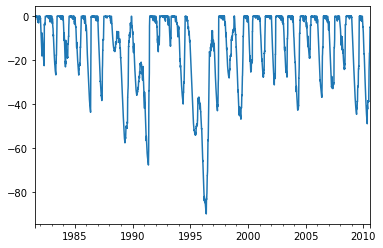

In [37]:
df.Sd.plot()

In [27]:
start_date, end_date

(datetime.datetime(1981, 8, 1, 0, 0), datetime.datetime(2010, 7, 31, 0, 0))

In [26]:
q_ts

,Q,sd_mmd,iqr_mmd,min_mmd,max_mmd,min7_mmd,max7_mmd,doymin,doymax,doy7min,doy7max,nr_mis_days,nr_av_days
date,,,,,,,,,,,,,
1980-12-31,0.218867,0.147059,0.071971,0.100915,0.812160,0.114542,0.772910,203.0,344.0,222.0,345.0,0.0,366.0
1981-12-31,0.184933,0.099595,0.073267,0.097459,0.660096,0.097854,0.444096,339.0,59.0,344.0,59.0,0.0,365.0
1982-12-31,0.244494,0.286108,0.082944,0.086365,1.693440,0.087881,1.360430,95.0,344.0,107.0,347.0,0.0,365.0
1983-12-31,0.383572,0.230993,0.287539,0.186624,1.168128,0.188352,1.153317,267.0,2.0,269.0,1.0,0.0,365.0
1984-12-31,0.372360,0.308517,0.244512,0.103680,1.658880,0.129353,1.494967,189.0,339.0,191.0,340.0,10.0,356.0
1985-12-31,0.256043,0.166266,0.095040,0.133056,0.978048,0.135525,0.892142,309.0,10.0,311.0,12.0,0.0,365.0
1986-12-31,0.209597,0.167364,0.067392,0.115776,1.017688,0.118541,0.988777,235.0,360.0,106.0,364.0,0.0,365.0
1987-12-31,0.425665,0.418560,0.301363,0.152064,2.291812,0.157455,1.993174,207.0,335.0,192.0,339.0,10.0,355.0
1988-12-31,0.350854,0.283887,0.221322,0.150336,1.659364,0.157994,1.544407,332.0,3.0,333.0,8.0,11.0,355.0


In [22]:
s

1

In [23]:
df_monthly_mean

,p,ep,ps,pm,pl,liq
1,12.689274,99.353264,0.593314,7.057272,11.956843,19.014115
2,13.774293,79.406499,0.779309,2.014137,12.843971,14.858108
3,11.643201,68.342969,0.872998,1.104693,10.642555,11.747248
4,8.826703,40.524345,2.136285,0.860119,6.593648,7.453767
5,36.336047,19.391448,15.622289,3.364099,20.315393,23.679493
6,48.479040,9.776765,26.437070,6.703104,21.510478,28.213582
7,57.871420,9.234807,31.670406,10.927897,25.566550,36.494447
8,42.910109,15.712727,24.664027,13.104601,17.775644,30.880245
9,13.520437,25.457969,7.058389,11.202382,6.313820,17.516202
10,5.286618,50.798068,1.486690,15.541503,3.741968,19.283472


In [25]:
hydro_year_start_month

8

In [24]:
pep_ts

,p,ep,tas,pm,pl,ps
time,,,,,,
1981-01-01,0.340544,2.623973,8.887856,0.000000,0.315613,0.021197
1981-01-02,0.042565,2.944852,9.228445,0.000000,0.039449,0.002649
1981-01-03,0.030332,3.270229,11.422747,0.011495,0.029022,0.000978
1981-01-04,0.155584,3.342314,10.744968,0.000000,0.148862,0.005016
1981-01-05,0.083922,3.413642,9.155314,0.000000,0.077779,0.005224
...,...,...,...,...,...,...
2010-12-27,0.157554,3.199998,11.966928,0.487793,0.153142,0.002685
2010-12-28,0.306276,2.794332,12.541137,0.598569,0.297698,0.005220
2010-12-29,1.652014,2.302444,12.619525,0.613691,1.605748,0.028154


In [ ]:
## 2
def run_sd_calculation(catch_id, pep_dir, q_dir, out_dir, snow_id_list):
    """
    run calculation of storage deficits (1)
    
    catch_id:    str, catchment id
    pep_dir:     str, dir, directory of P and Ep timeseries
    q_dir:       str, dir, directory of Q timeseries
    out_dir:     str, dir, output directory
    
    returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
    """
    
    # get P Ep and Q files for catch id
    f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')
    f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

    # read files as dataframes
    q_ts = pd.read_csv(f_q[0],index_col=0)
    q_ts.index = pd.to_datetime(q_ts.index)
    pep_ts = pd.read_csv(f_pep[0],index_col=0)
    pep_ts.index = pd.to_datetime(pep_ts.index)

    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
    df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

    # find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
    p_ep_start_year = pep_ts.index.year[0]
    q_start_year = int(q_ts.index[0].year)
    p_ep_end_year = pep_ts.index.year[-1]
    q_end_year = int(q_ts.index[-1].year)

    # test if timeseries have overlap -> if not don't continue the sd calculation
    if q_start_year>p_ep_end_year:
        a=1
    elif p_ep_start_year>q_end_year:
        a=1
    else:
        a=0
        start_year = max(q_start_year,p_ep_start_year)
        end_year = min(q_end_year,p_ep_end_year)
        start_date = datetime(start_year,hydro_year_start_month,1)
        end_date = datetime(end_year,hydro_year_start_month,1)
        end_date = end_date - timedelta(days=1)

        #calculate mean Q for startdate enddate timeseries
        q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
        sd_input[['p','ep']] = pep_ts[['p','ep']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

        # run sd calculation
        b = sd_initial(sd_input, si_0, si_max, q_mean)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
        if b==0:      
            # save output dataframe from sd calculation
            out = sd_initial(sd_input, si_0, si_max, q_mean)[1]
            out.to_csv(f'{out_dir}/{catch_id}.csv')
            return out

### elevation - compare GSIM with EE elevations

In [14]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
e = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats.csv',index_col=0)
elmean_c = c['el_mean']
elmean_e = e['mean_ele']
elmean_e = elmean_e[elmean_c.index]

In [15]:
elmean_c

za_0000167    910.93810
de_0000129    366.14600
es_0000787    215.31020
br_0001831    404.11950
es_0001076    513.93300
                ...    
fr_0000086    296.59330
ca_0001025    275.47540
br_0001145    159.95630
138113A       299.09436
us_0005811     50.24471
Name: el_mean, Length: 6385, dtype: float64

In [16]:
elmean_e

za_0000167    1706.726357
de_0000129     822.974830
es_0000787     733.850821
br_0001831     763.771812
es_0001076    1112.233733
                 ...     
fr_0000086     658.923437
ca_0001025     436.571883
br_0001145     270.115109
138113A        310.761185
us_0005811     101.947844
Name: mean_ele, Length: 6385, dtype: float64

Text(0, 0.5, 'earth engine')

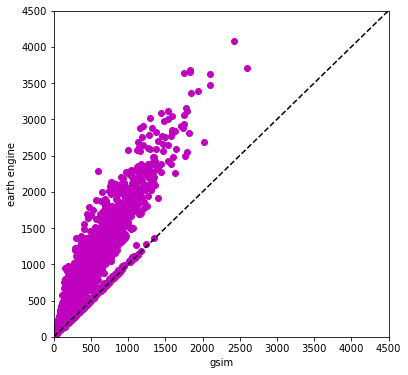

In [21]:
plt.figure(figsize=(6,6))
plt.plot(elmean_c,elmean_e,'mo')
plt.plot([0,5000],[0,5000],'k--')
plt.xlim(0,4500)
plt.ylim(0,4500)
plt.xlabel('gsim')
plt.ylabel('earth engine')

In [83]:
# check for which catchments we didn't get elevation from EE - returned nan values
e1 = e
e2 = e.dropna()
ixe1 = e1.index
ixe2 = e2.index
dif = list(set(ixe1) - set(ixe2)) #list of missing catch ids

In [85]:
# which of these catchments are also inside 'c' after removing catchments based on wb and area
ci = c.index
d = list(set(dif)-set(ci))

d2 = list(set(dif)-set(d))
c2 = c.loc[d2]
c2

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,el_min,el_max,drd,slp_mean,cla,snd,slt,tpi,lat,lon
ca_0006039,0.854513,0.925400,0.259154,-6.624199,0.923399,0.736734,49.635561,41.829162,6,44,...,0.0,540.0,NaN,0.126339,8.643045,24.21747,17.45670,3.59505,65.558515,-123.976820
ca_0006122,1.226705,0.539621,0.881927,-9.750881,2.273269,0.204825,40.525001,35.804167,5,29,...,0.0,352.0,NaN,0.437319,7.927163,20.45433,17.00221,2.19923,63.804850,-68.494080
se_0000064,2.125910,0.971738,1.421355,1.410507,2.187739,0.338469,30.653603,24.170247,3,18,...,0.0,1156.0,NaN,0.432655,4.818506,22.42491,17.74960,2.64058,61.788754,12.231329
fi_0000031,1.759720,1.184140,0.840864,3.737551,1.486074,0.556621,34.399995,26.510000,3,21,...,0.0,167.0,NaN,0.112351,4.986343,32.17280,16.94147,3.68892,62.533159,23.743632
no_0000181,2.164502,0.902997,1.403676,0.955011,2.397020,0.305836,29.573586,23.405532,2,16,...,0.0,1660.0,NaN,0.789719,4.117766,18.43353,14.88525,1.85256,62.000556,11.867023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
no_0000148,3.078219,1.022000,2.990796,4.240280,3.011954,0.286849,24.300003,19.226667,2,14,...,0.0,478.0,NaN,0.770989,3.934524,22.58929,16.92262,1.66702,63.305495,10.635000
ru_0000229,1.563261,0.655210,1.045552,-0.776798,2.385893,0.393589,35.345062,27.624553,3,19,...,0.0,360.0,NaN,0.249901,7.291093,27.92991,21.84351,3.43352,67.999488,36.654858
se_0000006,3.189160,0.881818,3.187244,1.143392,3.616574,0.190493,25.782161,20.618770,3,16,...,0.0,936.0,NaN,0.951393,5.093537,29.74013,23.48658,3.12238,63.544716,12.274469
se_0000039,3.729413,0.655512,2.430855,-1.790407,5.689314,0.130236,33.027419,25.562251,2,16,...,0.0,1709.0,NaN,1.187540,5.223706,26.91397,21.62889,2.68349,65.961596,15.487249


In [89]:
c2.lat.max()

74.56292110009794

In [88]:
c[c.lat>60]

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,el_min,el_max,drd,slp_mean,cla,snd,slt,tpi,lat,lon
ca_0006011,1.068386,1.229340,0.362148,-2.499857,0.869073,0.821591,51.823970,41.553275,6,33,...,0.0,501.0,NaN,0.089429,7.521332,17.09863,13.663080,2.72529,61.157696,-120.904867
se_0000084,1.884382,1.091367,1.101005,1.293873,1.726626,0.413382,34.484045,27.222048,3,19,...,0.0,670.0,NaN,0.268458,1.901685,13.52214,9.516089,1.37371,64.243919,18.651841
fi_0000104,1.779133,0.903127,1.031528,0.779404,1.969969,0.452720,39.444527,30.777119,3,17,...,0.0,489.0,NaN,0.295263,4.178745,35.62503,20.629590,3.66424,66.853319,26.420293
ru_0000476,1.428933,0.852563,1.019678,-1.268639,1.676043,0.502188,43.436408,34.651838,3,18,...,0.0,243.0,NaN,0.147817,6.822229,21.50154,21.425250,3.12432,66.248676,48.537162
no_0000131,3.448317,0.668136,2.836658,-0.922751,5.161103,0.124984,25.232815,19.621626,3,18,...,0.0,1931.0,NaN,2.934420,5.218721,27.04477,19.317670,1.96740,62.261448,8.083892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ca_0005960,1.562351,0.982704,1.193548,-4.369381,1.589849,0.364302,48.001229,36.117907,3,18,...,0.0,2361.0,NaN,2.191880,5.867181,20.62809,17.674920,2.08528,61.051504,-128.351149
no_0000209,1.592324,0.605243,1.140502,-2.789031,2.630884,0.326910,38.675352,29.772907,3,16,...,0.0,1002.0,NaN,0.454174,6.716036,27.03722,23.661340,3.25647,69.152663,23.147598
no_0000108,8.787342,1.690431,7.968675,6.266903,5.198285,0.122741,18.824999,15.641667,2,15,...,0.0,906.0,NaN,2.959390,5.841075,30.10540,22.687890,2.21167,61.238398,5.565485
ca_0003887,0.993282,1.070433,0.602201,-4.103479,0.927925,0.745298,50.146368,41.578843,5,28,...,0.0,534.0,NaN,0.460368,10.196180,30.57599,21.622240,4.55379,60.495958,-108.574995


In [29]:
dif = elmean_e-elmean_c
dif = dif[dif<20]
dif.index

Index(['136203A', '138004B', 'nl_0000022', 'us_0006452', '406214',
       'dk_0000021', 'A5030502', '410761', '403209A', 'us_0001814',
       ...
       '304499', '610008', '408202', '116006B', 'fr_0000349', '122004A',
       '105102A', 'A2390531', 'de_0000616', '138113A'],
      dtype='object', length=225)

In [32]:
c.loc['408202']

p_mean          1.753612
ep_mean         2.053088
q_mean          0.150251
t_mean         12.767641
ai              0.854134
hai             1.174906
tdiff_max      16.600000
tdiff_mean     13.103333
idu_mean        5.000000
idu_max        26.000000
hpd_mean        1.000000
hpd_max         2.000000
hpf             0.052569
lpf             0.707767
si_p            0.234710
si_ep           0.461066
phi             5.000000
de              0.699398
dp              0.419098
dt              5.962560
sp              0.353384
st              0.808832
se              0.741258
sd             -0.455448
sti             0.058467
ftf             0.000000
tc              0.160142
ntc             0.782924
nonveg          0.056935
area           76.600000
ir_mean              NaN
el_mean       398.317719
el_min        275.000000
el_max        783.631165
drd             0.800528
slp_mean       11.740000
cla            18.000000
snd            69.000000
slt                  NaN
tpi                  NaN


In [ ]:
# HYDROSHEDS ELEVATION

In [101]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
e = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats_hydrosheds.csv',index_col=0)
elmean_c = c['el_mean']
elmean_e = e['mean_ele']
elmean_e = elmean_e[elmean_c.index]

Text(0, 0.5, 'earth engine')

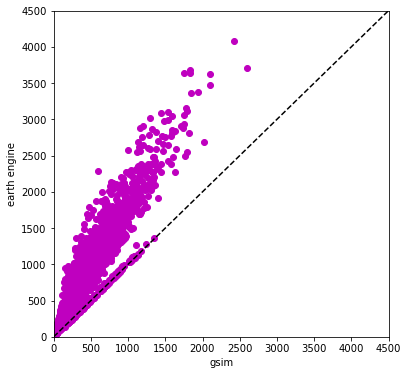

In [102]:
plt.figure(figsize=(6,6))
plt.plot(elmean_c,elmean_e,'mo')
plt.plot([0,5000],[0,5000],'k--')
plt.xlim(0,4500)
plt.ylim(0,4500)
plt.xlabel('gsim')
plt.ylabel('earth engine')

Text(0, 0.5, 'earth engine')

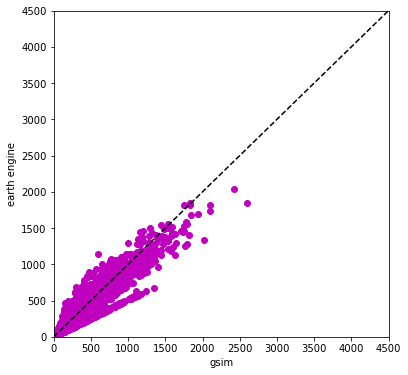

In [100]:
plt.figure(figsize=(6,6))
plt.plot(elmean_c,elmean_e*0.5,'mo')
plt.plot([0,5000],[0,5000],'k--')
plt.xlim(0,4500)
plt.ylim(0,4500)
plt.xlabel('gsim')
plt.ylabel('earth engine')

Text(0, 0.5, 'hydrosheds')

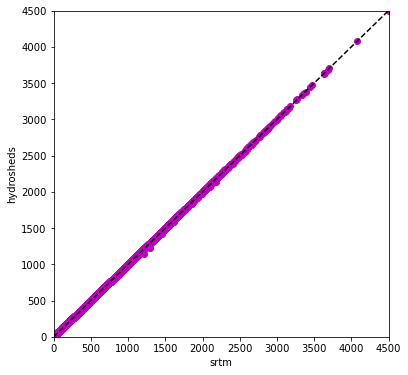

In [98]:
e1 = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats.csv',index_col=0)
e2 = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats_hydrosheds.csv',index_col=0)
plt.figure(figsize=(6,6))
plt.plot(e1.mean_ele,e2.mean_ele,'mo')
plt.plot([0,5000],[0,5000],'k--')
plt.xlim(0,4500)
plt.ylim(0,4500)
plt.xlabel('srtm')
plt.ylabel('hydrosheds')

In [112]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
e = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_slope_stats_hydrosheds.csv',index_col=0)
elmean_c = c['slp_mean']
elmean_e = e['mean_slope']
elmean_e = elmean_e[elmean_c.index]
dif = elmean_e-elmean_c

Text(0, 0.5, 'earth engine')

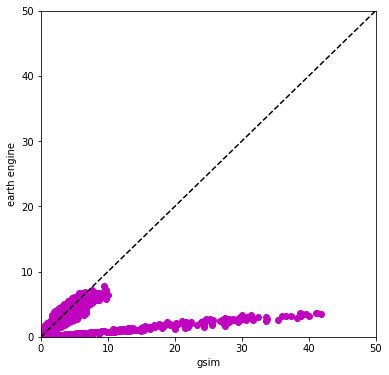

In [117]:
plt.figure(figsize=(6,6))
plt.plot(elmean_c,elmean_e*0.3,'mo')
plt.plot([0,5000],[0,5000],'k--')
plt.xlim(0,50)
plt.ylim(0,50)
plt.xlabel('gsim')
plt.ylabel('earth engine')

In [113]:
dfp = dif[dif>0]
difn = dif[dif<0]

In [114]:
dfp

za_0000167    5.207601
de_0000129    4.074500
es_0000787    4.103918
br_0001831    1.304497
es_0001076    4.813014
                ...   
us_0006131    0.394640
fr_0000086    7.482152
ca_0001025    1.552259
br_0001145    1.038410
us_0005811    0.568635
Length: 5943, dtype: float64

In [115]:
difn

226407     -19.276423
136203A    -10.393493
222213     -17.050426
138004B     -9.830894
406214      -4.084832
              ...    
122004A    -20.587955
401217     -23.193560
105102A    -10.939566
A2390531    -0.787112
138113A    -16.836647
Length: 214, dtype: float64

### SNOW

In [127]:
# select catchments with snow -> catchments in which T < 0 more frequent than 5% of total timeseries
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:]
snow_catch=[]
for catch_id in catch_id_list:
    a = pd.read_csv(f'{work_dir}/output/forcing_timeseries/processed/daily/{catch_id}_1981_2010.csv',index_col=0)
    t = a[a.tas<0]
    if (len(t))>0:
        if (len(t)>0.05*len(a)):
            snow_catch.append(catch_id)

In [133]:
np.savetxt(f'{work_dir}/output/snow/catch_id_list_snow.txt',snow_catch,fmt='%s')

In [135]:
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow.txt',dtype='str')[:]
snow_id_list

array(['ar_0000023', 'ar_0000024', 'ar_0000025', ..., 'us_0008778',
       'us_0008779', 'us_0008782'], dtype='<U10')

In [91]:
# select catchments with temperature <0 AND precipitation>1, because if no p there is no snow possible
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:]
snow_catch=[]
for catch_id in catch_id_list:
    a = pd.read_csv(f'{work_dir}/output/forcing_timeseries/processed/daily/{catch_id}_1981_2010.csv',index_col=0)
    t = a[(a.tas<0)&(a.p>1)]
    if (len(t))>0:
        if (len(t)>0.05*len(a)):
            snow_catch.append(catch_id)

In [94]:
np.savetxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',snow_catch,fmt='%s')

In [95]:
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')[:]
snow_id_list

array(['ar_0000023', 'ar_0000024', 'ar_0000025', ..., 'us_0008723',
       'us_0008726', 'us_0008766'], dtype='<U10')

In [170]:
gsim_cc = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)

catch_id = snow_id_list[1000]
print(catch_id)
a = pd.read_csv(f'{work_dir}/output/forcing_timeseries/processed/daily/{catch_id}_1981_2010.csv',index_col=0)
cc = gsim_cc.loc[catch_id.upper()]
el_avg = cc['ele.mean']
el_min = cc['ele.min']
el_max = cc['ele.max']
el_q1 = cc['ele.q1']
el_q2 = cc['ele.q2']
el_q3 = cc['ele.q3']
al = cc['altitude.dem']
al2 = cc['altitude.meta']

ca_0003188


In [171]:
print(el_min, el_q1, el_q2, el_avg, el_q3, el_max)
print(al,al2)

0.0 0.0 0.0 314.2596 649.0 831.0
494.0 nan


In [146]:
gsim_cc.columns

Index(['long.org', 'lat.org', 'long.new', 'lat.new', 'dist.km', 'area.meta',
       'area.est', 'quality', 'altitude.meta', 'altitude.dem', 'climate.type',
       'no.dams', 'sto.volume', 'dr.mean', 'dr.min', 'dr.q1', 'dr.q2', 'dr.q3',
       'dr.max', 'ele.mean', 'ele.min', 'ele.q1', 'ele.q2', 'ele.q3',
       'ele.max', 'ir.mean', 'ir.min', 'ir.q1', 'ir.q2', 'ir.q3', 'ir.max',
       'landcover.type', 'lithology.type', 'nl.mean', 'nl.min', 'nl.q1',
       'nl.q2', 'nl.q3', 'nl.max', 'pop.count', 'pd.mean', 'pd.min', 'pd.q1',
       'pd.q2', 'pd.q3', 'pd.max', 'slp.mean', 'slp.min', 'slp.q1', 'slp.q2',
       'slp.q3', 'slp.max', 'sb.mean', 'sb.min', 'sb.q1', 'sb.q2', 'sb.q3',
       'sb.max', 'scl.mean', 'scl.min', 'scl.q1', 'scl.q2', 'scl.q3',
       'scl.max', 'snd.mean', 'snd.min', 'snd.q1', 'snd.q2', 'snd.q3',
       'snd.max', 'slt.mean', 'slt.min', 'slt.q1', 'slt.q2', 'slt.q3',
       'slt.max', 'soil.type', 'tp.mean', 'tp.min', 'tp.q1', 'tp.q2', 'tp.q3',
       'tp.max'],
    

In [128]:
len(snow_catch)

4239

In [129]:
len(catch_id_list)

8658

In [116]:
t

,p,tas,ep
time,,,
1981-01-01,1.852582,-17.467869,0.000000
1981-01-02,0.279875,-23.143702,0.000000
1981-01-03,8.282399,-9.073090,0.023547
1981-01-04,19.997992,-5.660555,0.000000
1981-01-05,4.764875,-10.163354,0.000000
...,...,...,...
2010-12-27,0.062805,-14.871116,0.000000
2010-12-28,1.167058,-10.753648,0.000000
2010-12-29,0.767139,-9.563906,0.000000


In [ ]:
for j in range(len(el_zones)-1):
    Ss = np.zeros(tmax) # snow storage
    Pm = np.zeros(tmax) # melt water
    Pl = np.zeros(tmax) # liquid precipitation
    Ps = np.zeros(tmax) # solid precipitation
    T = np.zeros(tmax) # temperature
    for i in range(0,tmax):               
        el_dif = mean_el - j*250-125
        dt = (el_dif/1000.)*6.4
        
        Tmean = t_tot[i]
        T[i] = Tmean+dt
        
        if T[i]>TT:
            Pl[i] = p_tot[i]
            Ps[i] = 0
            
            Pm[i] = min(Ss[i],MF*(T[i]-TT))
            Ss[i] = max(0, Ss[i]-Pm[i])
        else:
            Ps[i] = p_tot[i]
            Pl[i] = 0
            Ss[i] = Ss[i]+Ps[i]
        if i<tmax-1:
            Ss[i+1] = Ss[i]

        df_Ss.iloc[:,j] = Ss
        df_Pm.iloc[:,j] = Pm
        df_Pl.iloc[:,j] = Pl
        df_Ps.iloc[:,j] = Ps
        df_T.iloc[:,j] = T
    
        # Pl into interception storage -> include this in Sd module
P = pd.DataFrame(index=df.index, columns=['Pm_tot','Pl_tot','Ps_tot'])
a_elzone = a_el[0:-1]
a_total = a_el[-1]
a_div = a_elzone/a_total
for k in range(len(P.index)):
    P.Pm_tot = a_div  * df_Pm.iloc[k]
    P.Pl_tot = a_div * df_Pl.iloc[k]


In [100]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:] # test for 3 catchments -> run on delftblue for all catchments
catch_id_list = catch_id_list[1:-221]
gsim_c = pd.read_csv(f'{work_dir}/data/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)

arr = gsim_c.index.values
a = np.array([x.lower() if isinstance(x, str) else x for x in arr])

gsim_c.index = a
gsim_c = gsim_c.loc[catch_id_list,:]
gsim_c = gsim_c[gsim_c['area.meta']<10000]
gsim_c = gsim_c[(gsim_c['lat.new']>30) | (gsim_c['lat.new']<-15)]

In [101]:
gsim_c

,long.org,lat.org,long.new,lat.new,dist.km,area.meta,area.est,quality,altitude.meta,altitude.dem,...,slt.q2,slt.q3,slt.max,soil.type,tp.mean,tp.min,tp.q1,tp.q2,tp.q3,tp.max
ar_0000009,-64.3700,-22.7200,-64.3729,-22.7229,0.4384,4450.0,4849.8548,Medium,405.0,573.0,...,21.0,27.0,31.0,Cambisols,1.86682,0.0,0.0,0.000000,2.968651,17.5901
ar_0000019,-65.6000,-27.1000,-65.6021,-27.0979,0.3124,620.0,565.7950,Medium,1500.0,514.0,...,0.0,25.0,30.0,Cambisols,1.71843,0.0,0.0,0.000000,2.921115,14.5249
ar_0000024,-69.6800,-31.9200,-69.6979,-31.8938,3.3657,4790.0,4829.0971,High,1925.0,2212.0,...,0.0,31.0,40.0,No dominant class,1.65511,-1.0,0.0,0.000000,2.619904,17.5082
ar_0000025,-69.6800,-31.8800,-69.6854,-31.8729,0.9392,8500.0,8436.1468,High,1900.0,2099.0,...,22.0,31.0,40.0,No dominant class,1.67096,-1.0,0.0,0.000000,2.634474,17.5082
ar_0000026,-69.7000,-31.9500,-69.7188,-31.9479,1.7880,3710.0,3483.9183,Medium,1950.0,2145.0,...,24.0,31.0,40.0,No dominant class,1.89012,-1.0,0.0,1.523803,2.837692,16.6044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zw_0000041,32.8000,-19.8500,32.7979,-19.8521,0.3204,131.0,125.7873,High,NaN,1210.0,...,17.0,18.0,21.0,Ferralsols,2.33210,0.0,0.0,2.419548,3.613304,11.4427
zw_0000065,31.9500,-18.9167,31.9521,-18.9146,0.3212,3383.0,3315.8260,High,NaN,886.0,...,0.0,11.0,20.0,Lixisols,2.42611,0.0,0.0,0.000000,4.665804,17.1980
zw_0000068,32.4333,-18.8833,32.4312,-18.8813,0.3133,2222.0,2223.1190,High,NaN,976.0,...,11.0,15.0,24.0,Lixisols,2.84170,0.0,0.0,2.855309,4.502155,16.6162
zw_0000077,29.2000,-19.9500,29.2021,-19.9521,0.3203,397.0,393.9916,High,NaN,1263.0,...,11.0,15.0,20.0,Luvisols,3.60718,0.0,0.0,4.498227,5.548860,14.3737


In [181]:
elmax = gsim_c['ele.max']
elmin = gsim_c['ele.min']
elq1 = gsim_c['ele.q1']
elq2 = gsim_c['ele.q2']
elq3 = gsim_c['ele.q3']
elavg = gsim_c['ele.mean']
alm = gsim_c['altitude.meta']
ald = gsim_c['altitude.dem']
eldif = elmax-elmin

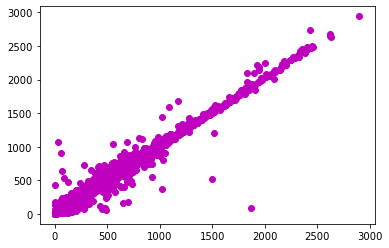

In [183]:
plt.plot(alm,ald,'mo')

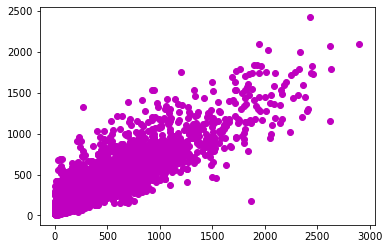

In [184]:
plt.plot(alm,elavg,'mo')

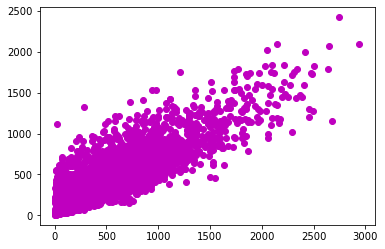

In [185]:
plt.plot(ald,elavg,'mo')

<AxesSubplot:>

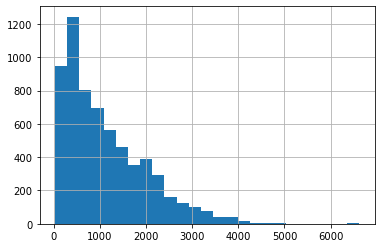

In [103]:
eldif.hist(bins=25)

<AxesSubplot:>

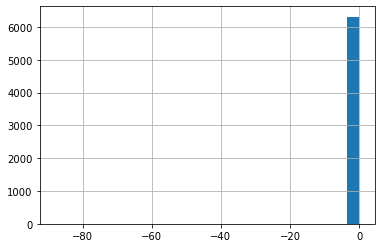

In [173]:
elmin.hist(bins=25)

<AxesSubplot:>

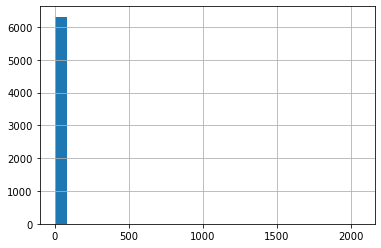

In [174]:
elq1.hist(bins=25)

<AxesSubplot:>

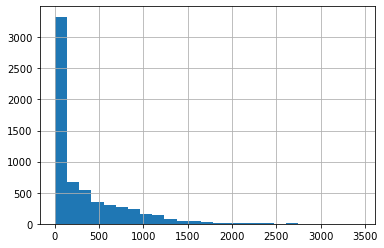

In [177]:
elq2.hist(bins=25)

<AxesSubplot:>

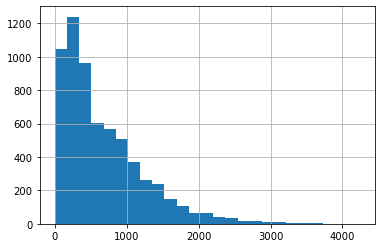

In [178]:
elq3.hist(bins=25)

<AxesSubplot:>

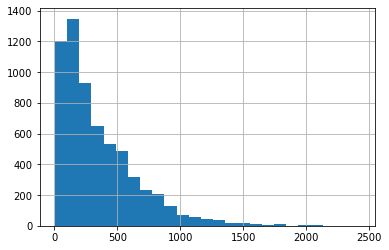

In [179]:
elavg.hist(bins=25)

<AxesSubplot:>

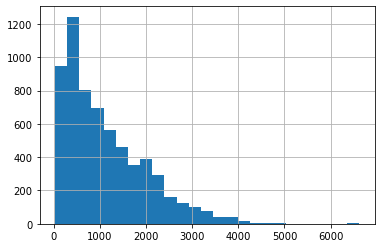

In [180]:
elmax.hist(bins=25)

In [75]:
gsim_c.columns

Index(['long.org', 'lat.org', 'long.new', 'lat.new', 'dist.km', 'area.meta',
       'area.est', 'quality', 'altitude.meta', 'altitude.dem', 'climate.type',
       'no.dams', 'sto.volume', 'dr.mean', 'dr.min', 'dr.q1', 'dr.q2', 'dr.q3',
       'dr.max', 'ele.mean', 'ele.min', 'ele.q1', 'ele.q2', 'ele.q3',
       'ele.max', 'ir.mean', 'ir.min', 'ir.q1', 'ir.q2', 'ir.q3', 'ir.max',
       'landcover.type', 'lithology.type', 'nl.mean', 'nl.min', 'nl.q1',
       'nl.q2', 'nl.q3', 'nl.max', 'pop.count', 'pd.mean', 'pd.min', 'pd.q1',
       'pd.q2', 'pd.q3', 'pd.max', 'slp.mean', 'slp.min', 'slp.q1', 'slp.q2',
       'slp.q3', 'slp.max', 'sb.mean', 'sb.min', 'sb.q1', 'sb.q2', 'sb.q3',
       'sb.max', 'scl.mean', 'scl.min', 'scl.q1', 'scl.q2', 'scl.q3',
       'scl.max', 'snd.mean', 'snd.min', 'snd.q1', 'snd.q2', 'snd.q3',
       'snd.max', 'slt.mean', 'slt.min', 'slt.q1', 'slt.q2', 'slt.q3',
       'slt.max', 'soil.type', 'tp.mean', 'tp.min', 'tp.q1', 'tp.q2', 'tp.q3',
       'tp.max'],
    

### CATCHMENT CHARACTERISTICS

In [118]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[0:10] # test for 3 catchments -> run on delftblue for all catchments with catch_characteristics.py
catch_id = catch_id_list[0]

In [120]:
j = catch_id
l = glob.glob(f'{work_dir}/output/forcing_timeseries/processed/daily/{j}*.csv') #find daily forcing (P Ep T) timeseries for catchment 
df = pd.read_csv(l[0], index_col=0)
df.index = pd.to_datetime(df.index)

In [131]:
print(catch_id)
p = df['p']
pmean = df['p'].mean()
high_p = []
count = 0
print(pmean)

for j in range(len(p)):
    if p[j] > (5*pmean):
        count += 1
    elif p[j] <= (5*pmean) and count > 0:
        high_p.append(count)
        count = 0 
if (len(high_p))>0:
    hpd_mean = np.round(np.mean(high_p),2)
else:
    hpd_mean=0        



102101A
5.013324183188193


In [132]:
hpd_mean

1.76

In [136]:
df['year'] = pd.DatetimeIndex(df.index).year
yearstart = df['year'][0]
yearend = df['year'][-1]
a = []
for year in range(yearstart,yearend+1):
    dfy = df[df['year']==year]
    p = dfy['p']
    pmean = dfy['p'].mean()
    high_p=[]
    count = 0
    for j in range(len(p)):
        if p[j] > (5*pmean):
            count += 1
        elif p[j] <= (5*pmean) and count > 0:
            high_p.append(count)
            count = 0 
    if (len(high_p))>0:
        a.append(max(high_p))
    else:
        a.append(0)
hpd_max = np.round(np.mean(a),2)

In [137]:
hpd_max

3.6

In [139]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
hpd = c.hpd_max

In [145]:
hpd.max()

2

In [151]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[0:50] # test for 3 catchments -> run on delftblue for all catchments with catch_characteristics.py
hpdmax=[]
hpdmean=[]
for catch_id in catch_id_list:
    j = catch_id
    l = glob.glob(f'{work_dir}/output/forcing_timeseries/processed/daily/{j}*.csv') #find daily forcing (P Ep T) timeseries for catchment 
    df = pd.read_csv(l[0], index_col=0)
    df.index = pd.to_datetime(df.index)
    
    p = df['p']
    pmean = df['p'].mean()
    high_p = []
    count = 0

    for j in range(len(p)):
        if p[j] > (5*pmean):
            count += 1
        elif p[j] <= (5*pmean) and count > 0:
            high_p.append(count)
            count = 0 
    if (len(high_p))>0:
        hpd_mean = np.round(np.mean(high_p),2)
    else:
        hpd_mean=0  
    hpdmean.append(hpd_mean)

    df['year'] = pd.DatetimeIndex(df.index).year
    yearstart = df['year'][0]
    yearend = df['year'][-1]
    a = []
    for year in range(yearstart,yearend+1):
        dfy = df[df['year']==year]
        p = dfy['p']
        pmean = dfy['p'].mean()
        high_p=[]
        count = 0
        for j in range(len(p)):
            if p[j] > (5*pmean):
                count += 1
            elif p[j] <= (5*pmean) and count > 0:
                high_p.append(count)
                count = 0 
        if (len(high_p))>0:
            a.append(max(high_p))
        else:
            a.append(0)
    hpd_max = np.round(np.mean(a),2)
    hpdmax.append(hpd_max)

In [152]:
hpdmean

[1.76,
 1.21,
 1.17,
 1.15,
 1.22,
 1.34,
 1.24,
 1.3,
 1.56,
 1.79,
 1.74,
 1.67,
 1.53,
 1.51,
 1.52,
 1.5,
 1.51,
 1.49,
 1.35,
 1.43,
 1.34,
 1.17,
 1.18,
 1.17,
 1.19,
 1.19,
 1.19,
 1.2,
 1.2,
 1.19,
 1.14,
 1.12,
 1.12,
 1.12,
 1.17,
 1.19,
 1.2,
 1.21,
 1.27,
 1.29,
 1.29,
 1.27,
 1.16,
 1.17,
 1.15,
 1.16,
 1.2,
 1.2,
 1.19,
 1.17]

In [153]:
hpdmax

[3.6,
 0.47,
 0.47,
 0.83,
 2.5,
 3.07,
 2.6,
 2.43,
 3.73,
 4.17,
 4.2,
 4.17,
 3.23,
 3.33,
 3.53,
 3.7,
 3.43,
 3.43,
 2.53,
 2.93,
 2.1,
 2.17,
 2.03,
 1.83,
 2.03,
 2.1,
 2.03,
 2.2,
 2.17,
 2.1,
 1.8,
 1.83,
 1.83,
 1.83,
 1.9,
 2.03,
 2.1,
 2.1,
 2.33,
 2.4,
 2.43,
 2.33,
 2.07,
 1.83,
 1.9,
 1.9,
 2.0,
 2.0,
 2.1,
 1.83]

In [3]:
## 1
def p_mean(df):
    """
    calculate mean precipitation
    df: pandas dataframe, P timeseries
    returns: mean P [mm/day]
    """
    m = df['p'].mean()
    return m

def ep_mean(df):
    """
    calculate mean potential evaporation
    df: pandas dataframe, Ep timeseries
    returns: mean Ep [mm/day]
    """
    m = df['ep'].mean()
    return m

def t_mean(df):
    """
    calculate mean temperature
    df: pandas dataframe, T timeseries
    returns: mean T [deg C]
    """
    m = df['tas'].mean()
    return m

def ai(df):
    """
    calculate aridity index (P/Ep)
    df: pandas dataframe, P and Ep timeseries
    returns: aridity index AI [-]
    """
    ai = df['p'].mean()/df['ep'].mean()
    return ai

def hai(df):
    """
    calculate holdridge aridity index 
    df: pandas dataframe, P and T timeseries
    returns:holdrige aridity index HAI [-]
    """
    pmean = df['p'].mean()
    t = df['tas']
    temp_adjusted = np.zeros(len(t))

    for i in range(1,len(t)):
        if t[i] < 0:
            temp_adjusted[i-1] = 0
        elif t[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = t[i]            

    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/len(t)))/(pmean*365)
    
    return HAI

def si_p(df):
    """
    calculate seasonality index of precipitation (see https://esd.copernicus.org/articles/12/725/2021/ for equation)
    df: pandas dataframe, P timeseries
    returns: seasonality index SI_P [-]
    """
    p = df['p']
    for j in p.index:
        if(j.month==1 and j.day==1):
            start_date = j
            break
    for j in p.index:
        if(j.month==12 and j.day==31):
            end_date = j

    p_annual = p.loc[start_date:end_date].groupby(pd.Grouper(freq="Y")).sum()
    pa = p_annual.mean()
    p_monthly = p.loc[start_date:end_date].groupby(pd.Grouper(freq="M")).sum()
    pm = p_monthly.groupby([p_monthly.index.month]).mean()

    a = np.zeros(12)
    for k in range(12):
        a[k] = np.abs(pm[k + 1]-(pa/12))
    if (pa>0):
        sip = (1/pa)*np.sum(a)
    else:
        sip = np.nan
    return sip
    
def si_ep(df):
    """
    calculate seasonality index of potential evaporation (see https://esd.copernicus.org/articles/12/725/2021/ for equation)
    df: pandas dataframe, Ep timeseries
    returns: seasonality index SI_Ep [-]
    """
    ep = df['ep']
    for j in ep.index:
        if(j.month==1 and j.day==1):
            start_date = j
            break
    for j in ep.index:
        if(j.month==12 and j.day==31):
            end_date = j
        
    ep_annual = ep.loc[start_date:end_date].groupby(pd.Grouper(freq="Y")).sum()
    epa = ep_annual.mean()
    ep_monthly = ep.loc[start_date:end_date].groupby(pd.Grouper(freq="M")).sum()
    epm = ep_monthly.groupby([ep_monthly.index.month]).mean()
    
    a = np.zeros(12)
    for k in range(12):
        a[k] = np.abs(epm[k + 1]-(epa/12))
    if (epa>0):
        siep = (1/epa)*np.sum(a)
    else:
        siep=np.nan
    return siep

def phi(df):
    """
    calculate phase lag (timing shift) between max Ep and max P 
    df: pandas dataframe, P and Ep timeseries
    returns: phase lag phi [months]
    """
    p = df['p']
    ep = df['ep']
    for j in p.index:
        if(j.month==1 and j.day==1):
            start_date = j
            break
    for j in p.index:
        if(j.month==12 and j.day==31):
            end_date = j
            
    p_annual = p.loc[start_date:end_date].groupby(pd.Grouper(freq="Y")).sum()
    pa = p_annual.mean()
    p_monthly = p.loc[start_date:end_date].groupby(pd.Grouper(freq="M")).sum()
    pm = p_monthly.groupby([p_monthly.index.month]).mean()
    ep_annual = ep.loc[start_date:end_date].groupby(pd.Grouper(freq="Y")).sum()
    epa = ep_annual.mean()
    ep_monthly = ep.loc[start_date:end_date].groupby(pd.Grouper(freq="M")).sum()
    epm = ep_monthly.groupby([p_monthly.index.month]).mean()
    
    epm_max_month = epm.idxmax()
    pm_max_month = pm.idxmax()
    phi = np.abs(epm_max_month - pm_max_month)
    if(phi>6):
        phi = 12 + min(epm_max_month,pm_max_month) - max(epm_max_month,pm_max_month)
    return phi

def q_mean(df_q):
    """
    calculate mean discharge
    df: pandas dataframe, Q timeseries
    returns: mean Q [mm/day]
    """
    m = df_q['Q'].mean()
    return m

def idu_mean(df):
    """
    interstorm duration: mean consecutive days of p<1mm
    df: pandas dataframe, P and Ep timeseries
    returns: idu_mean [days]
    """
    p = df['p']
    interstorm = []
    count = 0

    for j in range(len(p)):
        if p[j] < 1:
            count += 1
        elif p[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    idu_mean = int(np.mean(interstorm))
    return idu_mean

def idu_max(df):
    """
    interstorm duration: mean annual maximum consecutive days of p<1mm
    df: pandas dataframe, P and Ep timeseries
    returns: idu_max [days]
    """
    df['year'] = pd.DatetimeIndex(df.index).year
    yearstart = df['year'][0]
    yearend = df['year'][-1]
    a = []
    for year in range(yearstart,yearend+1):
        dfy = df[df['year']==year]
        p = dfy['p']
        interstorm=[]
        count = 0
        for j in range(len(p)):
            if p[j] < 1:
                count += 1
            elif p[j] >= 1 and count > 0:
                interstorm.append(count)
                count = 0 
        a.append(max(interstorm))
    idu_max = int(np.mean(a))
    return idu_max

def hpd_mean(df):
    """
    high precipitation days: mean consecutive days of p>5*pmean
    df: pandas dataframe, P and Ep timeseries
    returns: hpd_mean [days]
    """
    p = df['p']
    pmean = df['p'].mean()
    high_p = []
    count = 0

    for j in range(len(p)):
        if p[j] > (5*pmean):
            count += 1
        elif p[j] <= (5*pmean) and count > 0:
            high_p.append(count)
            count = 0 
    hpd_mean = int(np.mean(high_p))
    return hpd_mean

def hpd_max(df):
    """
    high precipitation days: mean annual max consecutive days of p>5*pmean
    df: pandas dataframe, P and Ep timeseries
    returns: hpd_max [days]
    """
    df['year'] = pd.DatetimeIndex(df.index).year
    yearstart = df['year'][0]
    yearend = df['year'][-1]
    a = []
    for year in range(yearstart,yearend+1):
        dfy = df[df['year']==year]
        p = dfy['p']
        pmean = dfy['p'].mean()
        high_p=[]
        count = 0
        for j in range(len(p)):
            if p[j] > (5*pmean):
                count += 1
            elif p[j] <= (5*pmean) and count > 0:
                high_p.append(count)
                count = 0 
        a.append(max(high_p))
    hpd_max = int(np.mean(a))
    return hpd_max

def hpf(df):
    """
    high precipitation frequency: days with p>5*pmean / total days
    df: pandas dataframe, P and Ep timeseries
    returns: hpf [-]
    """
    p = df['p']
    pmean = df['p'].mean()
    count = 0

    for j in range(len(p)):
        if p[j] > (5*pmean):
            count += 1
    hpf = count/len(p)
    return hpf

def lpf(df):
    """
    low precipitation frequency: days with p<1mm / total days
    df: pandas dataframe, P and Ep timeseries
    returns: lpf [-]
    """
    p = df['p']
    count = 0

    for j in range(len(p)):
        if p[j] <1:
            count += 1
    lpf = count/len(p)
    return lpf

def ftf(df):
    """
    freezing temperatures frequency: days with T<0 degreeC / total days
    df: pandas dataframe, tas timeseries
    returns: ftf [-]
    """
    t = df['tas']
    count = 0
    for j in range(len(t)):
        if t[j] < 0:
            count += 1
    ftf = count/len(t)
    return ftf

def tdiff_mean(df):
    """
    mean temperature difference: monthly mean t max - monthly mean t min
    df: pandas dataframe, tas timeseries
    returns: tdiff_mean [-]
    """
    df['year'] = pd.DatetimeIndex(df.index).year
    yearstart = df['year'][0]
    yearend = df['year'][-1]
    tdiff = []
    for year in range(yearstart,yearend+1):
        dfy = df[df['year']==year]
        dfy = dfy.groupby(pd.Grouper(freq="M")).mean()
        t = dfy['tas']
        tmax = dfy['tas'].max()
        tmin = dfy['tas'].min()
        tdiff.append(tmax-tmin)
    tdiff_mean = np.mean(tdiff)
    return tdiff_mean

def tdiff_max(df):
    """
    max temperature difference: monthly mean t max - monthly mean t min
    df: pandas dataframe, tas timeseries
    returns: tdiff_max [-]
    """
    df['year'] = pd.DatetimeIndex(df.index).year
    yearstart = df['year'][0]
    yearend = df['year'][-1]
    tdiff = []
    for year in range(yearstart,yearend+1):
        dfy = df[df['year']==year]
        dfy = dfy.groupby(pd.Grouper(freq="M")).mean()
        t = dfy['tas']
        tmax = dfy['tas'].max()
        tmin = dfy['tas'].min()
        tdiff.append(tmax-tmin)
    tdiff_max = np.max(tdiff)
    return tdiff_max

In [4]:
#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days

#Compute the seasonality variability indexes
def seas_var_indices(df):
    """
    calculate seasonality variability indices from Berghuijs 2014
    de, dp, dt: seasonal ep, p and t amplitudes
    sp, st, se: phase shifts of p, t and ep
    sd: phase difference between p and ep
    sti: seasonality timing index
    df: pandas dataframe, P and Ep timeseries
    returns: de,dp,dt,sp,st,se,sd,sti
    """
    global T_mean
    global P_mean
    global E_mean
    global T_obs
    global P_obs
    global E_obs
    
    data_d = df.resample('d').mean().bfill()
    daily_sliced_mean = df.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)

    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    for k in range(1,13):
        for j in range(1,len(daily_sliced_mean['tas'][k])+1):
            T1[count] = daily_sliced_mean['tas'][k,j]
            P1[count] = daily_sliced_mean['p'][k,j]
            E1[count] = daily_sliced_mean['ep'][k,j]
            count += 1
    t = np.linspace(1,366,366)

    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]

    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366

    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    #Compute Seasonality Timing index
    sti = ST_calc(res_P.x,res_T.x)

    return de,dp,dt,sp,st,se,sd,sti

In [90]:
def catch_characteristics_climate(var_cl, catch_id):
    cc_cl = pd.DataFrame(index=[catch_id], columns=var_cl)
    j = catch_id
    l = glob.glob(f'{fol_in}/forcing_timeseries/processed/daily/{j}*.csv') #find daily forcing (P Ep T) timeseries for catchment 
    df = pd.read_csv(l[0], index_col=0)
    df.index = pd.to_datetime(df.index)

    l_q = glob.glob(f'{fol_in}/q_timeseries_selected/{j}*.csv') # find discharge data for catchment
    df_q = pd.read_csv(l_q[0], index_col=0)
    df_q.index = pd.to_datetime(df_q.index)

    # calculate catchment characteristics using functions in (1)
    if 'p_mean' in var_cl:
        cc_cl.loc[j,'p_mean'] = p_mean(df)

    if 'q_mean' in var_cl:
        cc_cl.loc[j,'q_mean'] = q_mean(df_q)

    if 'ep_mean' in var_cl:
        cc_cl.loc[j,'ep_mean'] = ep_mean(df)

    if 't_mean' in var_cl:
        cc_cl.loc[j,'t_mean'] = t_mean(df)

    if 'ai' in var_cl:
        cc_cl.loc[j,'ai'] = ai(df)

    if 'si_p' in var_cl:
        cc_cl.loc[j,'si_p'] = si_p(df)

    if 'si_ep' in var_cl:
        cc_cl.loc[j,'si_ep'] = si_ep(df)    

    if 'phi' in var_cl:
        cc_cl.loc[j,'phi'] = phi(df)

    if 'tdiff_mean' in var_cl:
        cc_cl.loc[j,'tdiff_mean'] = tdiff_mean(df)
    if 'tdiff_max' in var_cl:
        cc_cl.loc[j,'tdiff_max'] = tdiff_max(df)

    if 'hai' in var_cl:
        cc_cl.loc[j,'hai'] = hai(df)
    if 'ftf' in var_cl:
        cc_cl.loc[j,'ftf'] = ftf(df)

    if 'idu_mean' in var_cl:
        cc_cl.loc[j,'idu_mean'] = idu_mean(df)
    if 'idu_max' in var_cl:
        cc_cl.loc[j,'idu_max'] = idu_max(df)

    if 'hpd_mean' in var_cl:
        cc_cl.loc[j,'hpd_mean'] = hpd_mean(df)
    if 'hpd_max' in var_cl:
        cc_cl.loc[j,'hpd_max'] = hpd_max(df)

    if 'hpf' in var_cl:
        cc_cl.loc[j,'hpf'] = hpf(df)
    if 'lpf' in var_cl:
        cc_cl.loc[j,'lpf'] = lpf(df)

    if ('sti') in var_cl:
        cc_cl.loc[j,['de','dp','dt','sp','st','se','sd','sti']] = seas_var_indices(df)
        
    return cc_cl

In [91]:
def catch_characteristics_landscape(var_lc,catch_id):
    cc_lc = pd.DataFrame(index=[catch_id], columns=var_lc)
    j = catch_id
    l = glob.glob(f'{fol_in}/forcing_timeseries/processed/daily/{j}*.csv') #find daily forcing (P Ep T) timeseries for catchment 
    df = pd.read_csv(l[0], index_col=0)
    df.index = pd.to_datetime(df.index)

    l_q = glob.glob(f'{fol_in}/q_timeseries_selected/{j}*.csv') # find discharge data for catchment
    df_q = pd.read_csv(l_q[0], index_col=0)
    df_q.index = pd.to_datetime(df_q.index)

    if 'tc' in var_lc:
        dft = pd.read_csv(f'{fol_in}/treecover/gsim_shapes_treecover.csv',index_col=0) #find treecover tables for catchment
        cc_lc.loc[j,'tc'] = dft.loc[j,'mean_tc'] /100
        cc_lc.loc[j,'ntc'] = dft.loc[j,'mean_ntc']/100
        cc_lc.loc[j,'nonveg'] = dft.loc[j,'mean_nonveg']/100

    if 'area' in var_lc:
        a = pd.read_csv(f'{fol_in}/catchment_area.csv',index_col=0)
        cc_lc.loc[j,'area'] = a.loc[j,'area']

    # add gsim variables
    gsim_var=['ir.mean','ele.mean','ele.min','ele.max','dr.mean','slp.mean','scl.mean','snd.mean','slt.mean','tp.mean']
    df_gsim = pd.read_csv(f'{data_dir}/GSIM_data/GSIM_metadata/GSIM_catalog/GSIM_catchment_characteristics.csv',index_col=0)
    k = j.upper()
    if k in df_gsim.index.values:
        cc_lc.loc[j,['ir_mean','el_mean','el_min','el_max','drd','slp_mean','cla','snd','slt','tpi']] = df_gsim.loc[k,gsim_var].values
    else:
        # use aus information
        df_aus = pd.read_csv(f'{data_dir}/CAMELS_AUS/CAMELS_AUS_Attributes-Indices_MasterTable.csv',index_col=0)
        cc_lc.loc[j,['el_mean','el_min','el_max','drd','slp_mean','cla','snd']] = df_aus.loc[j,['elev_mean','elev_min','elev_max','strdensity','mean_slope_pct','claya','sanda']].values  
        cc_lc.loc[j,['ir_mean','slt','tpi']] = np.nan # not available for camels aus    
    return cc_lc

In [96]:
def catch_characteristics(var_lc,var_cl, catch_id, fol_in, fol_out):
    cc_lc = catch_characteristics_landscape(var_lc,catch_id)
    cc_cl = catch_characteristics_climate(var_cl, catch_id)
    cc = pd.concat([cc_cl,cc_lc],axis=1)
    cc.to_csv(f'{fol_out}/catchment_characteristics/{j}.csv') #store cc dataframe

In [ ]:
var_lc=['tc','ntc','nonveg','area','ir_mean','el_mean','el_min','el_max','drd','slp_mean','cla','snd','slt','tpi']
var_cl=['p_mean','ep_mean','q_mean','t_mean','ai','hai','tdiff_max','tdiff_mean','idu_mean','idu_max','hpd_mean','hpd_max','hpf','lpf','si_p','si_ep','phi','de','dp','dt','sp','st','se','sd','sti','ftf']

In [97]:
cc

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,ir_mean,el_mean,el_min,el_max,drd,slp_mean,cla,snd,slt,tpi
ar_0000025,1.082337,1.220504,0.464726,1.903072,0.886795,0.452194,13.051013,10.994018,11,51,...,0.0,1838.457712,0.0,6621.0,0.60524,6.45049,8.792678,26.562758,15.139805,1.67096


In [4]:
## 2 
def catch_characteristics(var, catch_id, fol_in, fol_out):
    """
    calculate catchment characteristics and store in dataframe
    var:             str, list, list of variables (options: p_mean, q_mean, ep_mean, t_mean, ai, si_p, si_ep, phi, tc)
    catch_id_list:   str, list, list of catchment ids
    fol_in:          str, dir, directory with timeseries data
    fol_out:         str, dir, directory where to store the output tables
    
    returns: table (cc) with catchment characteristics for all catchments       
    """
    # make cc dataframe
    cc = pd.DataFrame(index=[catch_id], columns=var)
    j = catch_id
    l = glob.glob(f'{fol_in}/forcing_timeseries/processed/daily/{j}*.csv') #find daily forcing (P Ep T) timeseries for catchment 
    df = pd.read_csv(l[0], index_col=0)
    df.index = pd.to_datetime(df.index)

    l_q = glob.glob(f'{fol_in}/q_timeseries_selected/{j}*.csv') # find discharge data for catchment
    df_q = pd.read_csv(l_q[0], index_col=0)
    df_q.index = pd.to_datetime(df_q.index)

    # calculate catchment characteristics using functions in (1)
    if 'p_mean' in var:
        cc.loc[j,'p_mean'] = p_mean(df)

    if 'q_mean' in var:
        cc.loc[j,'q_mean'] = q_mean(df_q)

    if 'ep_mean' in var:
        cc.loc[j,'ep_mean'] = ep_mean(df)

    if 't_mean' in var:
        cc.loc[j,'t_mean'] = t_mean(df)

    if 'ai' in var:
        cc.loc[j,'ai'] = ai(df)

    if 'si_p' in var:
        cc.loc[j,'si_p'] = si_p(df)

    if 'si_ep' in var:
        cc.loc[j,'si_ep'] = si_ep(df)    

    if 'phi' in var:
        cc.loc[j,'phi'] = phi(df)

    # get tree cover statistics 
    if 'tc' in var:
        # l = glob.glob(f'{fol_in}/treecover/{j}*.csv') #find treecover tables for catchment
        # dft = pd.read_csv(l[0], index_col=0)
        # cc.loc[j,'tc'] = dft.loc[j,'mean_tc']
        # cc.loc[j,'ntc'] = dft.loc[j,'mean_ntc']
        # cc.loc[j,'nonveg'] = dft.loc[j,'mean_nonveg']
        dft = pd.read_csv(f'{fol_in}/treecover/gsim_shapes_treecover.csv',index_col=0) #find treecover tables for catchment
        cc.loc[j,'tc'] = dft.loc[j,'mean_tc']
        cc.loc[j,'ntc'] = dft.loc[j,'mean_ntc']
        cc.loc[j,'nonveg'] = dft.loc[j,'mean_nonveg']

    a = pd.read_csv(f'{fol_in}/catchment_area.csv',index_col=0)
    cc.loc[j,'area'] = a.loc[j,'area']
            
    cc.to_csv(f'{fol_out}/catchment_characteristics/{j}.csv') #store cc dataframe
    return cc

In [5]:
# define variables of interest
var=['p_mean','ep_mean','q_mean','t_mean','ai','si_p','si_ep','phi','tc','ntc','nonveg','area']

In [6]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:] # test for 3 catchments -> run on delftblue for all catchments
#catch_id_list = np.genfromtxt(f'/scratch/fransjevanoors/dif.csv',dtype='str')[:] # test for 3 catchments -> run on delftblue for all catchments
